In [1]:
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch
from tqdm.auto import tqdm
from torchvision.utils import make_grid

In [2]:
device: str = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device(device)

In [3]:
import os
import random
from PIL import Image
from torch.utils.data import Dataset

class CUBAttributesDatasetWithClass(Dataset):
    def __init__(self, root_dir, transform=None, max_attributes=7):
        self.root_dir = root_dir
        self.transform = transform
        self.max_attributes = max_attributes

        with open(os.path.join(root_dir, 'images.txt'), 'r') as f:
            self.image_paths = {int(line.split()[0]): line.strip().split()[1] for line in f.readlines()}

        with open(os.path.join(root_dir, 'attributes', 'attributes.txt'), 'r') as f:
            self.attribute_names = {int(line.split()[0]): line.strip().split(' ', 1)[1].replace('_', ' ') for line in f.readlines()}

        self.image_attributes = {}
        with open(os.path.join(root_dir, 'attributes', 'image_attribute_labels.txt'), 'r') as f:
            for line in f:
                parts = line.strip().split()
                image_id = int(parts[0])
                attribute_id = int(parts[1])
                is_present = int(parts[2])
                if is_present:
                    if image_id not in self.image_attributes:
                        self.image_attributes[image_id] = []
                    self.image_attributes[image_id].append(attribute_id)

        with open(os.path.join(root_dir, 'classes.txt'), 'r') as f:
            self.class_names = {}
            for line in f:
                parts = line.strip().split()
                class_id = int(parts[0])
                full_name = parts[1]
                bird_name = full_name[4:]
                bird_name = bird_name.replace('_', ' ')
                self.class_names[class_id] = bird_name
        
                with open(os.path.join(root_dir, 'image_class_labels.txt'), 'r') as f:
                    self.image_class_labels = {int(line.split()[0]): int(line.split()[1]) for line in f.readlines()}

        self.image_ids = sorted(self.image_paths.keys())

    def clean_attribute(self, attr_text):
        attr_text = attr_text.replace('has ', '')
        attr_text = attr_text.replace('::', ' ')
        attr_text = attr_text.replace('shape', '')
        attr_text = attr_text.replace('pattern', '')
        attr_text = attr_text.replace('color', '')
        attr_text = attr_text.replace('size', '')
        attr_text = attr_text.replace('bill', 'beak')
        attr_text = attr_text.replace('primary', '')
        attr_text = attr_text.replace('breast', 'chest')
        attr_text = attr_text.replace('upperparts', 'back')
        attr_text = attr_text.replace('underparts', 'belly')
        attr_text = attr_text.strip()
        attr_text = ' '.join(attr_text.split())
        return attr_text

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.root_dir, 'images', self.image_paths[image_id])

        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        attribute_ids = self.image_attributes.get(image_id, [])
        attribute_list = [self.clean_attribute(self.attribute_names[attr_id]) for attr_id in attribute_ids]

        attribute_list = list(set(attribute_list))

        random.shuffle(attribute_list)
        attribute_list = attribute_list[:self.max_attributes]

        class_id = self.image_class_labels[image_id]
        class_name = self.class_names[class_id]

        if attribute_list:
            caption = f"A {class_name} bird with " + ', '.join(attribute_list) + "."
        else:
            caption = f"A {class_name} bird."

        return image, caption


In [4]:
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

root_dir = '.\\CUB_200_2011\\CUB_200_2011'

dataset = CUBAttributesDatasetWithClass(root_dir=root_dir, transform=transform)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

for images, captions in dataloader:
    print(captions[2])
    break

A Tropical Kingbird bird with small (5 - 9 in), beak all-purpose, perching-like, under tail grey, wing rounded-wings, beak length shorter than head, head plain.


In [5]:
def denormalize(img, mean, std):
    mean = torch.tensor(mean).view(-1, 1, 1)
    std = torch.tensor(std).view(-1, 1, 1)
    return img * std + mean

In [6]:
images[0].min()

tensor(-2.0494)

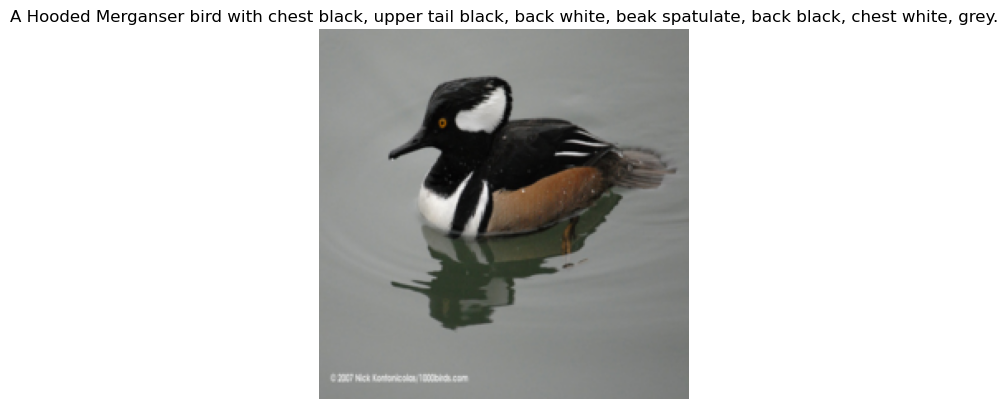

In [7]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img = images[0]
if isinstance(img, torch.Tensor):
    img = denormalize(img, mean, std).clamp(0, 1) 
    img = T.ToPILImage()(img)

plt.imshow(img)
plt.axis('off')
plt.title(captions[0], fontsize=12)
plt.show()

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, in_dim * 4),
            nn.LayerNorm(in_dim * 4),
            nn.ReLU(),
            nn.Linear(in_dim * 4, out_dim),
        )

    def forward(self, x):
        return self.net(x)

class AffineModule(nn.Module):
    def __init__(self, text_dim, num_channels):
        super().__init__()
        self.fc_gamma = MLP(text_dim, num_channels)
        self.fc_beta = MLP(text_dim, num_channels)
        self.norm = nn.InstanceNorm2d(num_channels, affine=False)

    def forward(self, x, text_feat):
        gamma = self.fc_gamma(text_feat).unsqueeze(-1).unsqueeze(-1)
        beta = self.fc_beta(text_feat).unsqueeze(-1).unsqueeze(-1)
        x = self.norm(x)
        return F.relu(gamma * x + beta)

class DeepFusionModule(nn.Module):
    def __init__(self, in_channels, out_channels, text_dim):
        super().__init__()
        self.affine1 = AffineModule(text_dim, in_channels)
        self.affine2 = AffineModule(text_dim, in_channels)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU()
        )
        self.res_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x, text_feat):
        x_res = self.res_conv(x)
        x_f = self.affine1(x, text_feat)
        x_f = self.affine2(x_f, text_feat)
        x_f = self.conv(x_f)
        return x_res + x_f

class GlobalFusionModule(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.depth_conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1, groups=channels)
        self.dilated_conv = nn.Conv2d(channels, channels, kernel_size=5, padding=6, dilation=3, groups=channels)
        self.pointwise_conv = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        x_f = F.relu(self.depth_conv(x))
        x_f = F.relu(self.dilated_conv(x_f))
        x_f = self.pointwise_conv(x_f)
        return x + x_f

class HFBlock(nn.Module):
    def __init__(self, in_channels, out_channels, text_dim):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.deep_fusion = DeepFusionModule(out_channels, out_channels, text_dim)
        self.global_fusion = GlobalFusionModule(out_channels)

    def forward(self, x, text_feat):
        x = self.upsample(x)
        x = self.deep_fusion(x, text_feat)
        x = self.global_fusion(x)
        return x

class HighCapacityGenerator(nn.Module):
    def __init__(self, z_dim=100, text_dim=512, start_channels=512, num_blocks=8):
        super().__init__()
        self.start_channels = start_channels
        self.init_proj = nn.Linear(z_dim, start_channels)
        self.blocks = nn.ModuleList()

        in_channels = start_channels
        for _ in range(num_blocks):
            out_channels = in_channels // 2 if in_channels > 32 else in_channels
            self.blocks.append(HFBlock(in_channels, out_channels, text_dim + z_dim))
            in_channels = out_channels

        self.to_rgb = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 2, kernel_size=3, padding=1),
            nn.InstanceNorm2d(in_channels // 2),
            nn.ReLU(),
            nn.Conv2d(in_channels // 2, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, z, text_feat):
        #text_feat = text_feat.float()
        #text_feat = F.normalize(text_feat.float(), dim=-1)
        text_cond = torch.cat([z, text_feat], dim=1)
        x = self.init_proj(z).view(z.size(0), self.start_channels, 1, 1)
        for block in self.blocks:
            x = block(x, text_cond)
        x = self.to_rgb(x)
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        return x


In [9]:
class AdapterA(nn.Module):
    def __init__(self, in_channels_list, out_channels=256):
        super().__init__()
        c1, c2, c3 = in_channels_list
        self.conv1 = nn.Sequential(
            nn.Conv2d(c1, c1, kernel_size=3, padding=1),
            nn.InstanceNorm2d(c1),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(c2, c2, kernel_size=3, padding=1),
            nn.InstanceNorm2d(c2),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(c3, c3, kernel_size=3, padding=1),
            nn.InstanceNorm2d(c3),
            nn.ReLU()
        )
        self.convf = nn.Sequential(
            nn.Conv2d(c3, out_channels, kernel_size=3, padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, feats):
        x0 = self.conv1(feats[0])
        x1 = self.conv2(feats[1])
        x2 = self.conv3(feats[2])
        x = x0 + x1 + x2  # Сложение всех трёх признаков
        return self.convf(x)


class AdapterB(nn.Module):
    def __init__(self, in_channels_list, out_channels=256):
        super().__init__()
        c1, c2, c3 = in_channels_list
        self.conv1 = nn.Sequential(
            nn.Conv2d(c1, c1, kernel_size=3, padding=1),
            nn.InstanceNorm2d(c1),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(c2, c2, kernel_size=3, padding=1),
            nn.InstanceNorm2d(c2),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(c2, out_channels, kernel_size=3, padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, feats):
        x0 = self.conv1(feats[0])
        x1 = self.conv2(feats[1] + x0)  # Сложение с x0
        x2 = self.conv3(feats[2] + x1)  # Сложение с x1
        return x2

class SubDiscriminator(nn.Module):
    def __init__(self, in_channels_list, adapter_class, text_dim=512, ass_channels=768):
        super().__init__()
        self.adapter = adapter_class(in_channels_list)
        self.text_proj = nn.Linear(text_dim, ass_channels)

        self.assessor = nn.Sequential(
            nn.Conv2d(ass_channels + 256, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.AdaptiveAvgPool2d(1)
        )

    def forward(self, img_feats, text_feat):
        """
        Args:
            img_feats: list of [feat1, feat2, feat3] от pre-encoder'а
            text_feat: текстовые эмбеддинги
        """
        text_feat = text_feat.float()
        #text_feat = F.normalize(text_feat.float(), dim=-1)
        #img_feats = [F.normalize(f.float(), dim=1) for f in img_feats]

        img_feats = self.adapter(img_feats)

        H, W = img_feats.shape[2:]
        text_feat_proj = self.text_proj(text_feat).unsqueeze(-1).unsqueeze(-1).expand(-1, -1, H, W)

        concat = torch.cat([img_feats, text_feat_proj], dim=1)
        out = self.assessor(concat)
        return out.view(out.size(0), -1)

In [11]:
def semantic_contrastive_loss(image_features, text_features, temperature=0.07):
    image_features = F.normalize(image_features, dim=-1)
    text_features = F.normalize(text_features, dim=-1)
    logits = (image_features @ text_features.T) / temperature
    labels = torch.arange(image_features.size(0), device=image_features.device)
    loss_i = F.cross_entropy(logits, labels)
    loss_t = F.cross_entropy(logits.T, labels)
    return (loss_i + loss_t) / 2

In [13]:
def compute_ma_gp(D, real_feats, real_text_feats, p=2, k=2):
    """
    Computes MA-GP regularization for discriminator D 
    based on features and text embeddings.

    Args:
        D: discriminator model (принимает готовые признаки)
        real_feats: extracted visual features (list of tensors, requires_grad=True)
        real_text_feats: extracted text features (requires_grad=True)
        p: power for gradient norm
        k: coefficient to scale MA-GP loss
    """
    real_text_feats.requires_grad_(True)
    
    if isinstance(real_feats, list):
        for feat in real_feats:
            feat.requires_grad_(True)
    else:
        real_feats.requires_grad_(True)

    real_logits = D(real_feats, real_text_feats)

    grad_real_embeds = torch.autograd.grad(
        outputs=real_logits,
        inputs=real_text_feats,
        grad_outputs=torch.ones_like(real_logits),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    grad_norm_embeds = torch.norm(grad_real_embeds.view(grad_real_embeds.size(0), -1), dim=1)

    if isinstance(real_feats, list):
        grads = torch.cat([
            torch.autograd.grad(
                outputs=real_logits,
                inputs=f,
                grad_outputs=torch.ones_like(real_logits),
                create_graph=True,
                retain_graph=True,
                only_inputs=True
            )[0].view(f.size(0), -1)
            for f in real_feats
        ], dim=1)
        grad_norm_feats = torch.norm(grads, dim=1)
    else:
        grad_real_feats = torch.autograd.grad(
            outputs=real_logits,
            inputs=real_feats,
            grad_outputs=torch.ones_like(real_logits),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]
        grad_norm_feats = torch.norm(grad_real_feats.view(grad_real_feats.size(0), -1), dim=1)

    grad_norm = grad_norm_feats + grad_norm_embeds

    ma_gp = (grad_norm ** p).mean() * k

    return ma_gp

def discriminator_loss(D_i, real_feats, fake_feats, matched_text, mismatched_text, lambda_gp=2.0):
    out_real = D_i(real_feats, matched_text)
    loss_real = F.relu(1.0 - out_real).mean()

    out_fake = D_i(fake_feats, matched_text)
    loss_fake = F.relu(1.0 + out_fake).mean()

    out_mismatch = D_i(real_feats, mismatched_text)
    loss_mismatch = F.relu(1.0 + out_mismatch).mean()

    gp = compute_ma_gp(D_i, real_feats, matched_text)

    return loss_real + 0.5 * (loss_fake + loss_mismatch) + lambda_gp * gp   

In [16]:
def generator_loss(D_i, fake_imgs, matched_text):
    """
    Computes adversarial generator loss from one sub-discriminator.

    Args:
        D_i: sub-discriminator model
        fake_imgs: generated images [B, C, H, W]
        matched_text: aligned text features [B, T]
    """
    out = D_i(fake_imgs, matched_text)  # [B, 1]
    return -out.mean()

In [17]:
import timm
import torch
import clip
from PIL import Image

model_encode, preprocess = clip.load("ViT-B/32")
Dino_model = timm.create_model('vit_small_patch8_224_dino', pretrained=True, features_only=True, out_indices=(0, 4, 8)).to(device)
Clip_model = timm.create_model("hf_hub:timm/vit_base_patch16_clip_224.openai",pretrained=True,features_only=True, out_indices=(1, 4, 8)).to(device)

H:\miniconda\envs\py311_dgm\Lib\site-packages\timm\models\_factory.py:126: UserWarning: Mapping deprecated model name vit_small_patch8_224_dino to current vit_small_patch8_224.dino.
  model = create_fn(


In [18]:
with torch.no_grad():
    dummy = torch.randn(1, 3, 224, 224).to(device)
    clip_feats = Clip_model(dummy)
    dino_feats = Dino_model(dummy)
    clip_channels = [f.shape[1] for f in clip_feats]
    dino_channels = [f.shape[1] for f in dino_feats]

In [19]:
#model_encode = model_encode.to(device)

In [20]:
# Cdiscrim = SubDiscriminator(768, AdapterA, Clip_model).to(device)
# Ddiscrim = SubDiscriminator(384, AdapterB, Dino_model).to(device)

# Cdiscrim = SubDiscriminator(768, AdapterSimple, Clip_model).to(device)
# Ddiscrim = SubDiscriminator(384, AdapterSimple, Dino_model).to(device)
Cdiscrim = SubDiscriminator(clip_channels, AdapterA).to(device)
Ddiscrim = SubDiscriminator(dino_channels, AdapterB).to(device)
Generator = HighCapacityGenerator().to(device)
#Generator = SimpleTextToImageGenerator().to(device)

In [21]:
discriminators = [Cdiscrim, Ddiscrim]
lambda_list = [1, 0.001]
lambda_clip = 4
lambda_fm = 10

In [22]:
for param in model_encode.parameters():
    param.requires_grad = False

In [23]:
# from itertools import chain
# optimizer_D_total = torch.optim.Adam(chain(Cdiscrim.parameters(), Ddiscrim.parameters()), 
#                                lr=4e-4, betas=(0.0, 0.9)
# )


from itertools import chain

optimizer_D_total = torch.optim.Adam(
    chain(
        Cdiscrim.adapter.parameters(),
        Cdiscrim.assessor.parameters(),
        Cdiscrim.text_proj.parameters(),
        Ddiscrim.adapter.parameters(),
        Ddiscrim.assessor.parameters(),
        Ddiscrim.text_proj.parameters(),
    ),
    lr=4e-4, betas=(0.0, 0.9)
)

In [24]:
optimizer_G = torch.optim.Adam(Generator.parameters(), 
                               lr=1e-4, betas=(0.0, 0.9)
)

In [25]:
def get_mismatched_features(text_features):
    B = text_features.size(0)
    # Random roll along batch
    shift = torch.randint(1, B, (1,)).item()  # ensure non-zero shift
    return text_features.roll(shifts=shift, dims=0)

In [26]:
n_epochs = 100

In [27]:
d_losses = []
g_losses = []

In [26]:
# checkpoint = torch.load('checkpoint.pth', map_location=device)

# Generator.load_state_dict(checkpoint['generator_state_dict'])
# optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])

# for d, state in zip(discriminators, checkpoint['discriminators_state_dict']):
#     d.load_state_dict(state)
# optimizer_D_total.load_state_dict(checkpoint['optimizer_D_state_dict'])

# start_epoch = checkpoint['epoch'] + 1
# d_losses = checkpoint['d_losses']
# g_losses = checkpoint['g_losses']


Epoch [1/100]:   0%|          | 0/369 [00:00<?, ?it/s]

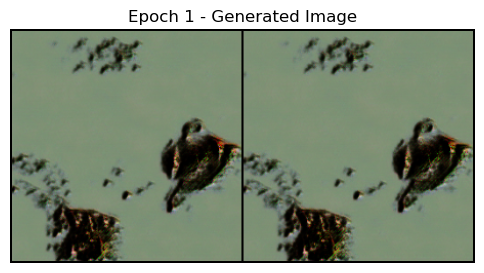

Epoch [2/100]:   0%|          | 0/369 [00:00<?, ?it/s]

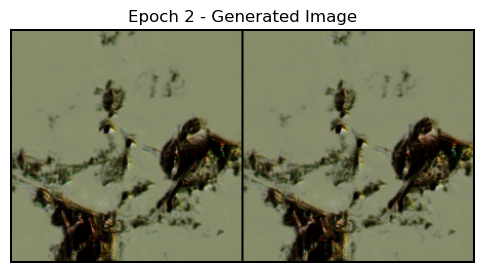

Epoch [3/100]:   0%|          | 0/369 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [28]:
for epoch in range(n_epochs):
    pbar = tqdm(dataloader, desc=f"Epoch [{epoch+1}/{n_epochs}]")
    epoch_d_loss = 0
    epoch_g_loss = 0
    num_batches = 0

    for i, (real_imgs, captions) in enumerate(pbar):
        batch_size_tmp = len(captions)
        real_imgs = real_imgs.to(device)

        # ====== Сначала заранее предобрабатываем все ======
        text_tokens = clip.tokenize(captions).to(device)

        with torch.no_grad():
            text_features = model_encode.encode_text(text_tokens)
            real_clip_feats = Clip_model(real_imgs)  # CLIP фичи
            real_dino_feats = Dino_model(real_imgs)  # DINO фичи

        mismatched_text = get_mismatched_features(text_features)

        # Генерация фейков
        z = torch.randn(batch_size_tmp, 100).to(device)
        fake_imgs = Generator(z, text_features)
        fake_imgs = (fake_imgs + 1.0) / 2.0
        # 2. Нормализация
        mean = torch.tensor([0.485, 0.456, 0.406], device=fake_imgs.device).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225], device=fake_imgs.device).view(1, 3, 1, 1)
        fake_imgs = (fake_imgs - mean) / std
        fake_imgs_detached = fake_imgs.detach()

        with torch.no_grad():
            fake_clip_feats = Clip_model(fake_imgs_detached)
            fake_dino_feats = Dino_model(fake_imgs_detached)

        # ======== Оптимизация дискриминаторов =========
        optimizer_D_total.zero_grad()
        d_total = 0
        for discriminator, feats_real, feats_fake, lam in zip(discriminators, [real_clip_feats, real_dino_feats], [fake_clip_feats, fake_dino_feats], lambda_list):
            loss_i = discriminator_loss(discriminator, feats_real, feats_fake, text_features, mismatched_text, lambda_gp=0.5) #5
            d_total += lam * loss_i
        d_total.backward()
        optimizer_D_total.step()

        # ======== Оптимизация генератора =========
        optimizer_G.zero_grad()
        total_g = 0.0
        fake_imgs = Generator(z, text_features)

        fake_clip_feats = Clip_model(fake_imgs)
        fake_dino_feats = Dino_model(fake_imgs)

        for discriminator, feats_fake, lam in zip(discriminators, [fake_clip_feats, fake_dino_feats], lambda_list):
            loss_i = generator_loss(discriminator, feats_fake, text_features)
            total_g += lam * loss_i

        image_features = model_encode.encode_image(fake_imgs)
        clip_loss = semantic_contrastive_loss(image_features, text_features)

        total_g += lambda_clip * clip_loss

        total_g.backward()
        optimizer_G.step()

        # Логирование
        epoch_d_loss += d_total.item()
        epoch_g_loss += total_g.item()
        num_batches += 1

        pbar.set_postfix({
            "D_loss": f"{d_total.item():.4f}",
            "G_loss": f"{total_g.item():.4f}",
        })

    d_losses.append(epoch_d_loss / num_batches)
    g_losses.append(epoch_g_loss / num_batches)

    # Генерация одного примера
    Generator.eval()
    with torch.no_grad():
        fake_imgs = Generator(z, text_features).cpu()
    grid = make_grid(fake_imgs[:2], nrow=2, normalize=True, value_range=(-1, 1))
    plt.figure(figsize=(6,6))
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.title(f"Epoch {epoch+1} - Generated Image")
    plt.axis("off")
    plt.show()
    Generator.train()

In [29]:
torch.save({
    'generator_state_dict': Generator.state_dict(),
    'optimizer_G_state_dict': optimizer_G.state_dict(),
    'discriminators_state_dict': [d.state_dict() for d in discriminators],
    'optimizer_D_state_dict': optimizer_D_total.state_dict(),
    'epoch': 4,
    'd_losses': d_losses,
    'g_losses': g_losses
}, 'checkpoint2.pth')